# Birds Exercise
- We want to build a model that can recognize what is a bird and not a bird from photos.
- Images are represented by pixels (numbers).

## Steps
1. Download images from DuckDuckGo of birds and non-birds (forests).
2. Train the model - i.e. fine-tune a pretrained neural network to recognise these two groups.
3. Try running the model and see if it works.

In [51]:
import time
from duckduckgo_search import DDGS 
import fastcore.all as fc 
from fastdownload import download_url
import fastai.vision.all as fv

def search_images(keywords, max_images=200): return fc.L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

# Step 1: Download images from DuckDuckGo search engine of birds and non-birds
- for non-birds, let's search for forests; because we can't search duckduckgo for non-bird

getting a bird photo
len(urls)=1, urls[0]='https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'


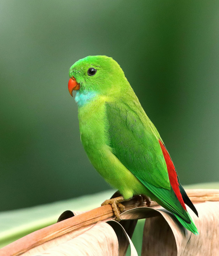

In [38]:

# get a bird photo
print("getting a bird photo")
urls = search_images('bird photos', max_images=1)  # search for image in duck duck go search engine
print(f'{len(urls)=}, {urls[0]=}')

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)
im = fv.Image.open(dest)
im.to_thumb(256, 256)

getting a forest photo


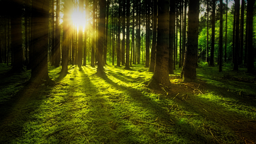

In [39]:
# get a forest photo
print("getting a forest photo")
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=True)
im = fv.Image.open('forest.jpg')
im.to_thumb(256, 256)

In [ ]:
searches = 'forest', 'bird'
path = fc.Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    fv.download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    fv.resize_images(path/o, max_size=400, dest=path/o)  # image no bigger than 400x400 pixels

# Step 2: Train the model
- first, remove images that failed to download correctly
- create a DataLoaders object, this contains a training set and a validation set
- use a pre-traimed computer vision model, resnet18, and fine-tune it. resenet is pretrained on imagenet with images covering 1000 categories.
- `fastai` comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model. fine tuning means adjusting the model's weights a little bit so that the model learns to recognize this new dataset. 

In [43]:
# remove images that failed to download correctly
failed = fv.verify_images(fv.get_image_files(path))  # path is Path object bird_or_not directory
failed.map(fc.Path.unlink)
print(f'{len(failed)=}')


len(failed)=12


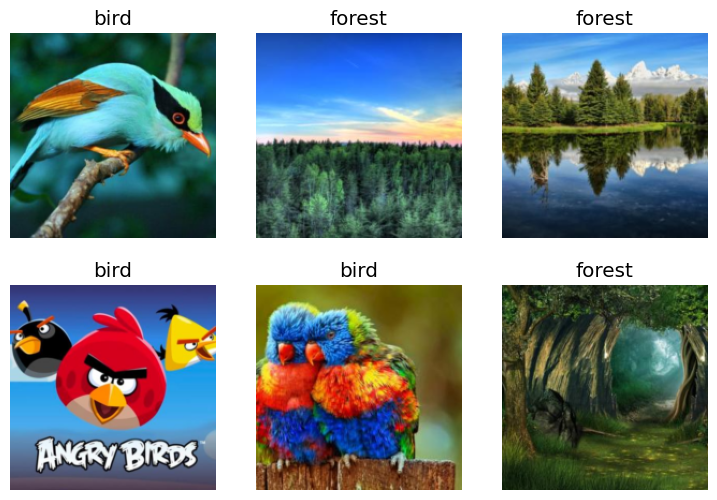

In [44]:
dls = fv.DataBlock(
    blocks = (fv.ImageBlock, fv.CategoryBlock),  # imputs to model are images and outputs are categories 'bird' and 'forest' 
    get_items = fv.get_image_files,  # to get all the inputs, run the get_image_files function, which returns a list of all image files in the path
    splitter = fv.RandomSplitter(valid_pct=0.2, seed=42),  # randomly split data into 80% training and 20% validation
    get_y = fv.parent_label,  # the labels (y values) is the name of the parent of each file, aka name of folder that images are in, 'bird' or 'forest'
    item_tfms = [fv.Resize(192, method='squash')],  # before training, resize each image to 192x192 pixels by squishing (as opposed to cropping) 
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = fv.vision_learner(dls, fv.resnet18, metrics=fv.error_rate)
learn.fine_tune(3)  # 3 epochs
# it runs through every photo, learning about what a forest looks like and a bird looks like

epoch,train_loss,valid_loss,error_rate,time
0,0.573662,0.362314,0.086957,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.090035,0.184320,0.014493,00:02
1,0.046328,0.199246,0.028986,00:02
2,0.031513,0.175936,0.028986,00:02


# Step 3: Use the model

In [49]:
is_bird, _, probs = learn.predict(fv.PILImage.create('bird.jpg'))
print('looking at bird.jpg')
print(f'This is a: {is_bird}')
print(f'Probability it\'s a bird: {probs[0]:.4f}')

looking at bird.jpg
This is a: bird
Probability it's a bird: 1.0000


In [48]:
is_bird, _, probs = learn.predict(fv.PILImage.create('forest.jpg'))
print('looking at forest.jpg')
print(f'This is a: {is_bird}')
print(f'Probability it\'s a bird: {probs[0]:.4f}')

looking at forest.jpg
This is a: forest
Probability it's a bird: 0.0000


# Inspiration
- DALL-E - for generating pictures
- a good course to take: [practical data ethics](https://ethics.fast.ai/)
- [meta learning](https://radekosmulski.com/the-post-tech-job-manifesto/)